In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [10]:
from pathlib import Path
import io
import base64
import random

import gym
from gym import wrappers
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import torch
from tqdm import tqdm

from lib import get_network
from lib.agent import DQN
from lib.logging import Logger
from lib.rollout import ReplayBuffer
from lib.utils import make_env, get_html_video_string, train, plot_progress

from IPython.display import HTML

plt.style.use('seaborn-v0_8')

### In this assignment you are going to:
* implement DQN and doubleDQN
* use them on CartPole, LunarLander and (Optionally) BreakOut environments

### We use PyTorch for neural networks. If you are new to PyTorch see tutorials:
https://pytorch.org/tutorials/ <br>
https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html

# CartPole

In [3]:
SEED = 0xCEEEEEEB
random.seed(SEED)
torch.manual_seed(SEED)
np.random.seed(SEED)

In [4]:
log_root = Path("results")
log_root.mkdir(exist_ok=True)

The next cell will embed a video of random policy playing CartPole-v1

In [5]:
env = make_env("CartPole-v1", monitor=True)
env.reset()
while True:
    action = env.action_space.sample()
    if env.step(action)[2]: break
env.close()

HTML(data=get_html_video_string(env.file_infix))

# Implementation
#### Task 1: Implement MLP network in `lib/network.py`
#### Task 2: Implement DQN in `lib/agent.py`

Now, run the next two cells. You should obtain the highest (500) reward in less than 100000 steps

Note! You can try to use small `target_update_every`. E.g. value of 1 corresponds to fitted Q-iteration. The expected outcome is unstable or even divergent behaviour

In [6]:
env = make_env("CartPole-v1", SEED)

value_network = get_network("mlp")(
    env.observation_space.shape[0],
    64,
    env.action_space.n)

agent = DQN(
    value_network,
    env.action_space,
    eps=.2,
    eps_decay=(.2 - .02) / 10**5,
    batch_size=32,
    learning_rate=5e-4,
    discount_factor=.99,
    double=False
)

In [7]:
agent = train(
    agent,
    env,
    log_dir=log_root / "cartpole-v1",
    prefix="_dqn",
    buffer_size=5 * 10**4,
    n_steps=10**5,
    warmup_steps=1000,
    target_update_every=500,
    log_every=500,
    save_every=1000,
)

/home/vsydorskyi/src/rl-assignments/lib/agent.py:91: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  v_s0 = FloatTensor(v_s0)


---------------------------------
| reward/reward_mean | 16.533   |
| reward/reward_max  | 59       |
| reward/reward_min  | 8        |
| reward/reward_std  | 8.233    |
| loss/bellman_error | 0.077375 |
| misc/q             | 1.1824   |
| misc/q_est         | 0.96476  |
| misc/epsilon       | 0.1973   |
| misc/timestep      | 1500     |
---------------------------------
---------------------------------
| reward/reward_mean | 10.894   |
| reward/reward_max  | 17       |
| reward/reward_min  | 8        |
| reward/reward_std  | 2.2144   |
| loss/bellman_error | 0.059302 |
| misc/q             | 2.1039   |
| misc/q_est         | 2.0452   |
| misc/epsilon       | 0.1964   |
| misc/timestep      | 2000     |
---------------------------------
---------------------------------
| reward/reward_mean | 13.297   |
| reward/reward_max  | 25       |
| reward/reward_min  | 9        |
| reward/reward_std  | 3.4238   |
| loss/bellman_error | 0.09709  |
| misc/q             | 2.963    |
| misc/q_est  

Now, let's take a look at our learned policy in action:

In [8]:
env = make_env("CartPole-v1", monitor=True)
obs = env.reset()
while True:
    obs = torch.FloatTensor(obs).unsqueeze(0)
    act = agent.pick_action(obs, force_greedy=True)
    obs, rew, done, info = env.step(act)
    if done: break
env.close()

HTML(data=get_html_video_string(env.file_infix))

The following cell plots a mean reward against training iterations. Note, that the agent may sometimes degrade its performance.

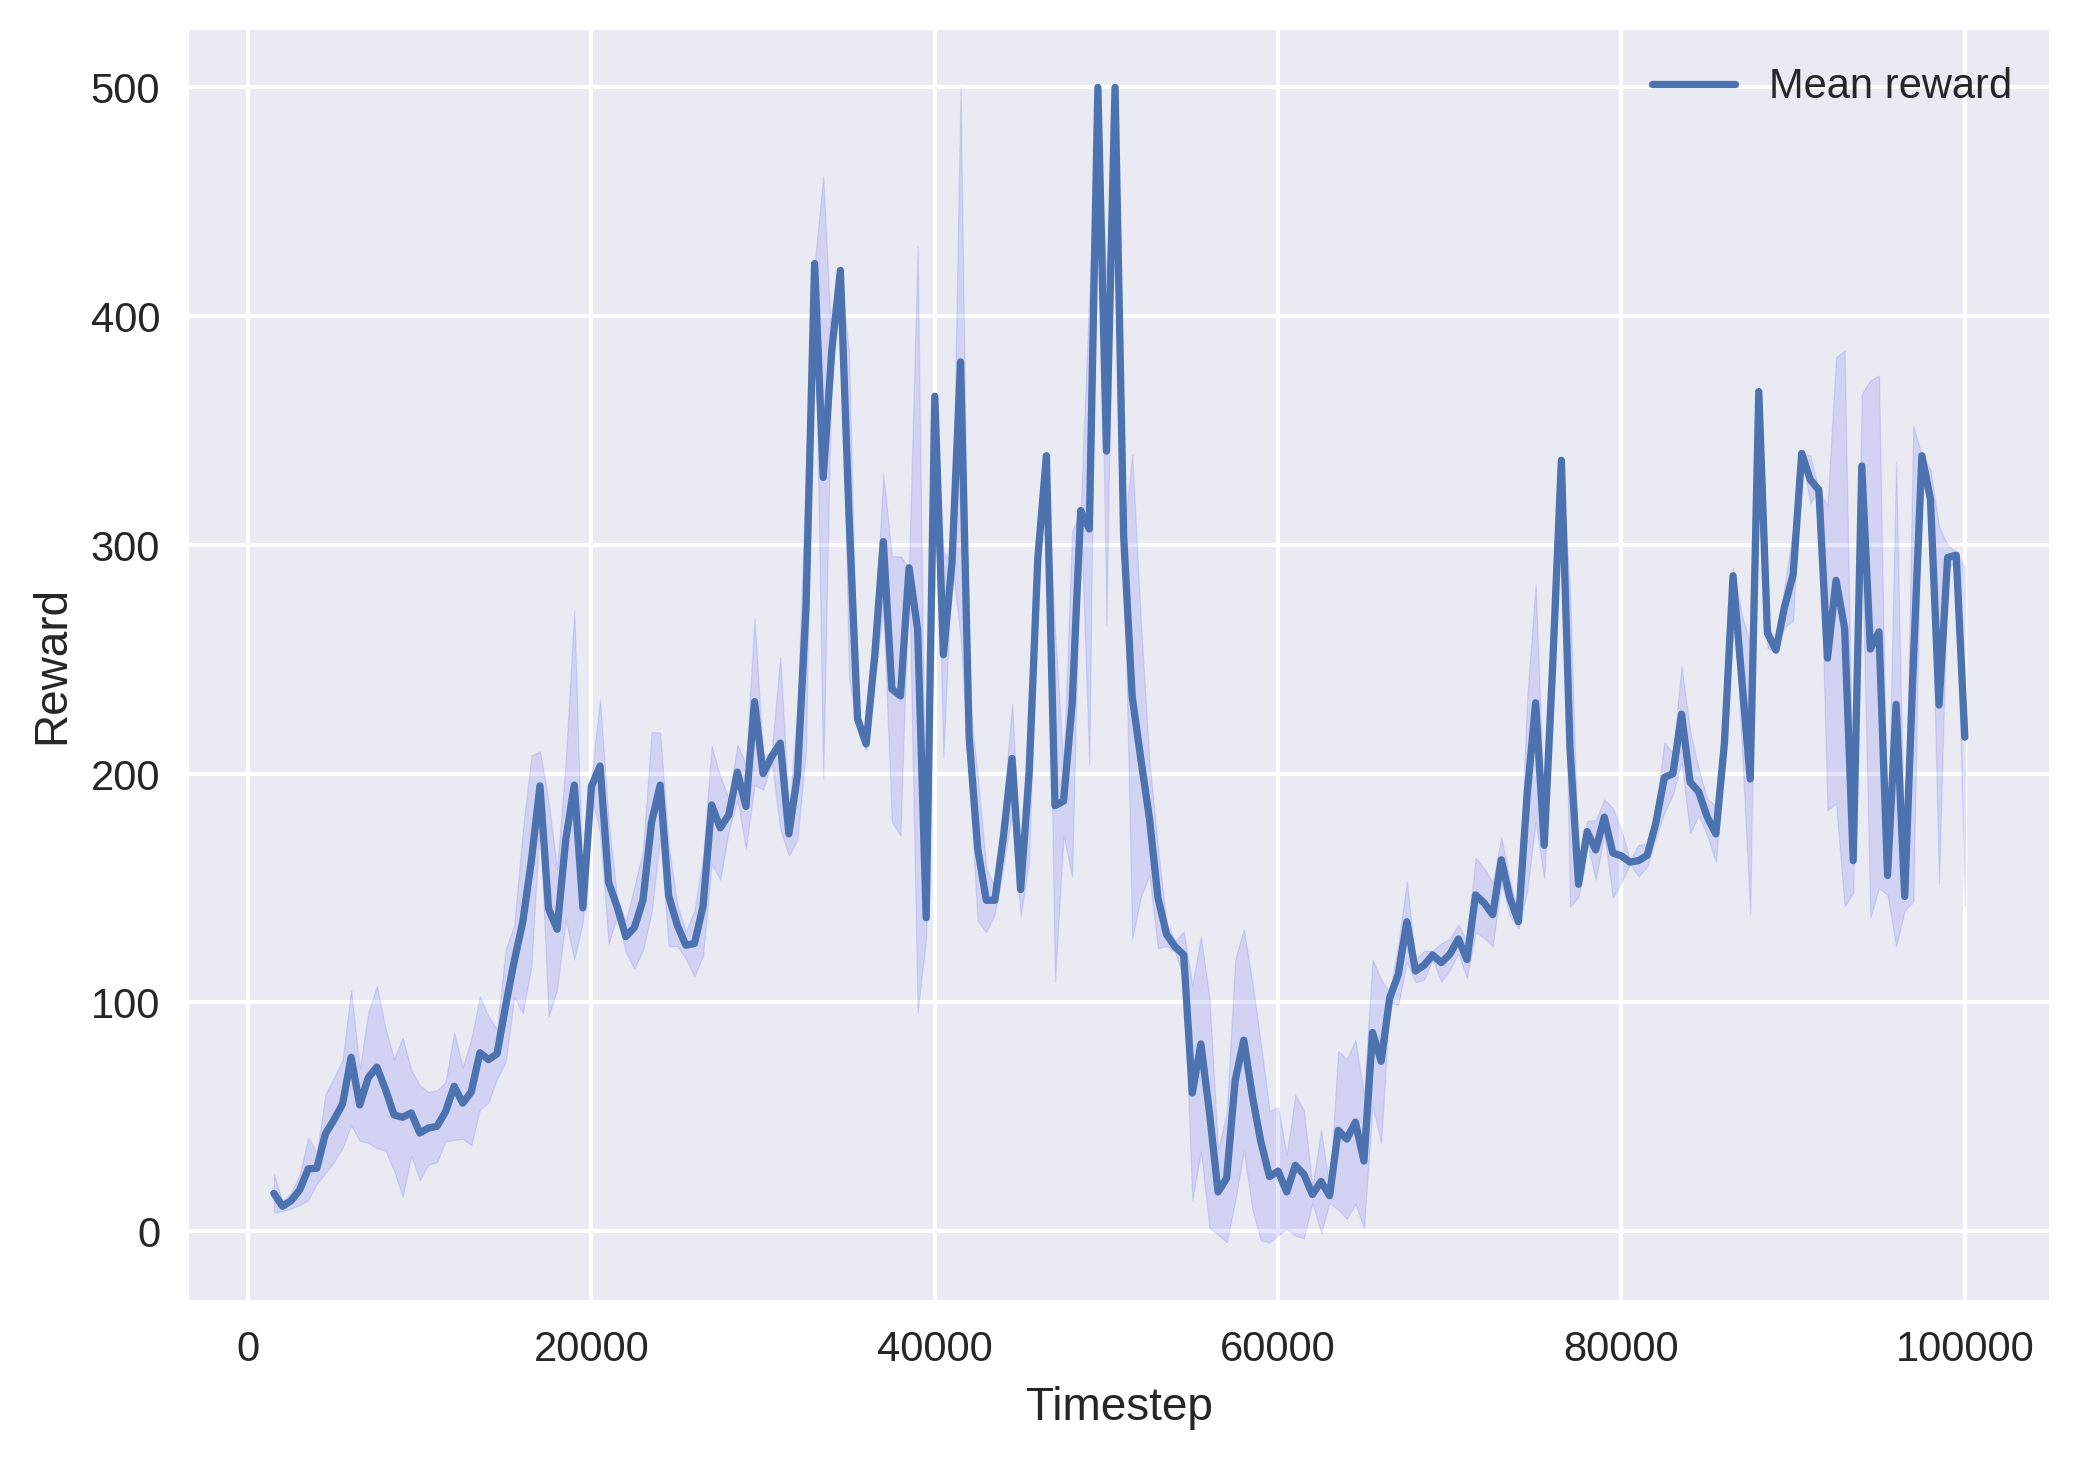

In [11]:
plt.figure(dpi=300)
df = pd.read_csv(str(log_root / "cartpole-v1" / "logs_dqn.csv"), sep=";")
plot_progress(df)